In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

In [2]:
data = pd.read_csv("../data/preparation/clean_dataset.csv")

data.head()

,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,CentralAir,SalePrice,GarageFinish_Fin,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,sin_MoSold,cos_MoSold
0,0.380070,0.375,0.333333,0.500,0.316729,1.0,208500,0.0,0.0,1.0,0.0,8.660254e-01,5.000000e-01
1,-0.312090,0.375,0.333333,0.875,0.069650,1.0,181500,0.0,0.0,1.0,0.0,5.000000e-01,-8.660254e-01
2,0.497489,0.375,0.333333,0.500,0.228124,1.0,223500,0.0,0.0,1.0,0.0,-1.000000e+00,-1.836970e-16
3,0.390885,0.375,0.333333,0.500,0.442583,1.0,140000,0.0,0.0,0.0,1.0,8.660254e-01,5.000000e-01
4,1.134029,0.500,0.333333,0.500,0.566894,1.0,250000,0.0,0.0,1.0,0.0,-2.449294e-16,1.000000e+00


## (1) Correlation investigation

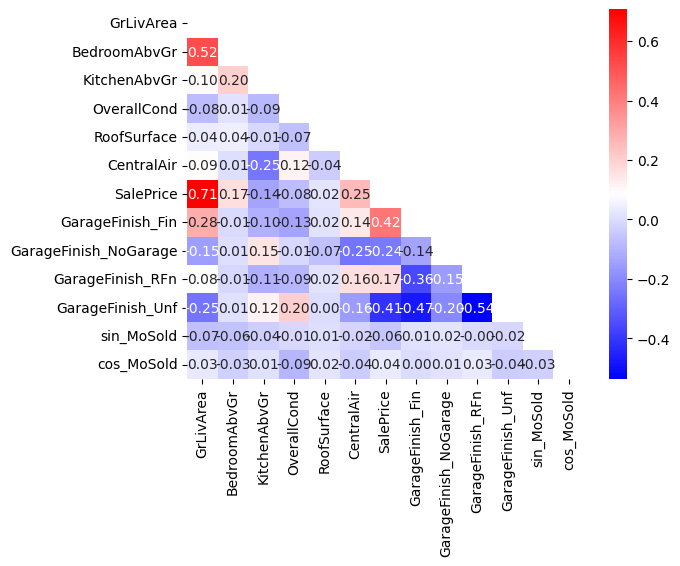

In [6]:
corr_matrix = data.select_dtypes('number').corr()
column_names = corr_matrix.columns

# Cria máscara para esconder triângulo superior e a diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    xticklabels=column_names, 
    yticklabels=column_names,
    cmap='bwr',
    annot=True, # mostra valores numericos
    fmt=".2f", # casas decimais
    cbar=True 
)
plt.show()

In [8]:
corr_df = corr_matrix.stack().reset_index()

corr_df.columns = ['feature_1','feature_2', 'correlation']

no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

corr_df.sort_values(by="absolute_correlation", ascending=False).head(5*2)

,feature_1,feature_2,correlation,absolute_correlation
6,GrLivArea,SalePrice,0.707685,0.707685
78,SalePrice,GrLivArea,0.707685,0.707685
127,GarageFinish_RFn,GarageFinish_Unf,-0.536355,0.536355
139,GarageFinish_Unf,GarageFinish_RFn,-0.536355,0.536355
13,BedroomAbvGr,GrLivArea,0.519712,0.519712
1,GrLivArea,BedroomAbvGr,0.519712,0.519712
137,GarageFinish_Unf,GarageFinish_Fin,-0.474129,0.474129
101,GarageFinish_Fin,GarageFinish_Unf,-0.474129,0.474129
85,SalePrice,GarageFinish_Fin,0.419678,0.419678
97,GarageFinish_Fin,SalePrice,0.419678,0.419678


## (2) Base Modelling

In [9]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

In [12]:
LR = LinearRegression()

scores = cross_val_score(LR, X, y, cv=10)
base_model_score = scores.mean()

base_model_score

np.float64(0.6458937653741824)

## (3) Feature Permutation

In [15]:
LR_model = LinearRegression().fit(X, y)

permutation_score = permutation_importance(LR_model, X, y, n_repeats=100)

importance_df = pd.DataFrame(np.vstack((X.columns, permutation_score.importances_mean)).T)
importance_df.columns=['feature', 'score decrease']

importance_df.sort_values(by="score decrease", ascending=False)

,feature,score decrease
0,GrLivArea,1.019594
1,BedroomAbvGr,0.065031
6,GarageFinish_Fin,0.051837
9,GarageFinish_Unf,0.020696
2,KitchenAbvGr,0.01943
5,CentralAir,0.015307
7,GarageFinish_NoGarage,0.012262
8,GarageFinish_RFn,0.011824
10,sin_MoSold,0.000927
3,OverallCond,0.000195


## (4) Modelling with less complexity

In [19]:
# Selecting the strongest features
strongest_features = X[["GrLivArea", "BedroomAbvGr", "GarageFinish_Fin", "GarageFinish_Unf", "KitchenAbvGr", "CentralAir"]]

# Re-instantiating a Linear Regression
l_reg = LinearRegression()

# Average accuracy of the cross-validated model
np.mean(cross_val_score(l_reg, strongest_features, y, cv=10))

np.float64(0.6376353182930797)